In [1]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.17.0
TF Hub version:  0.16.1
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

71918/71918 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
2684586/2684586 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


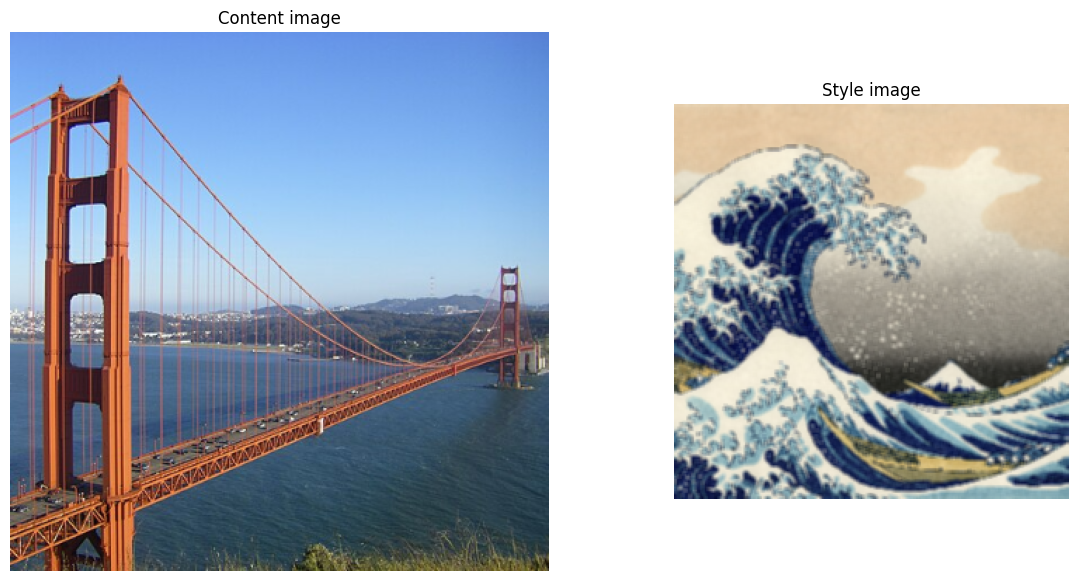

In [4]:
content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (though, other sizes work as
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [5]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [6]:
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

In [7]:
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

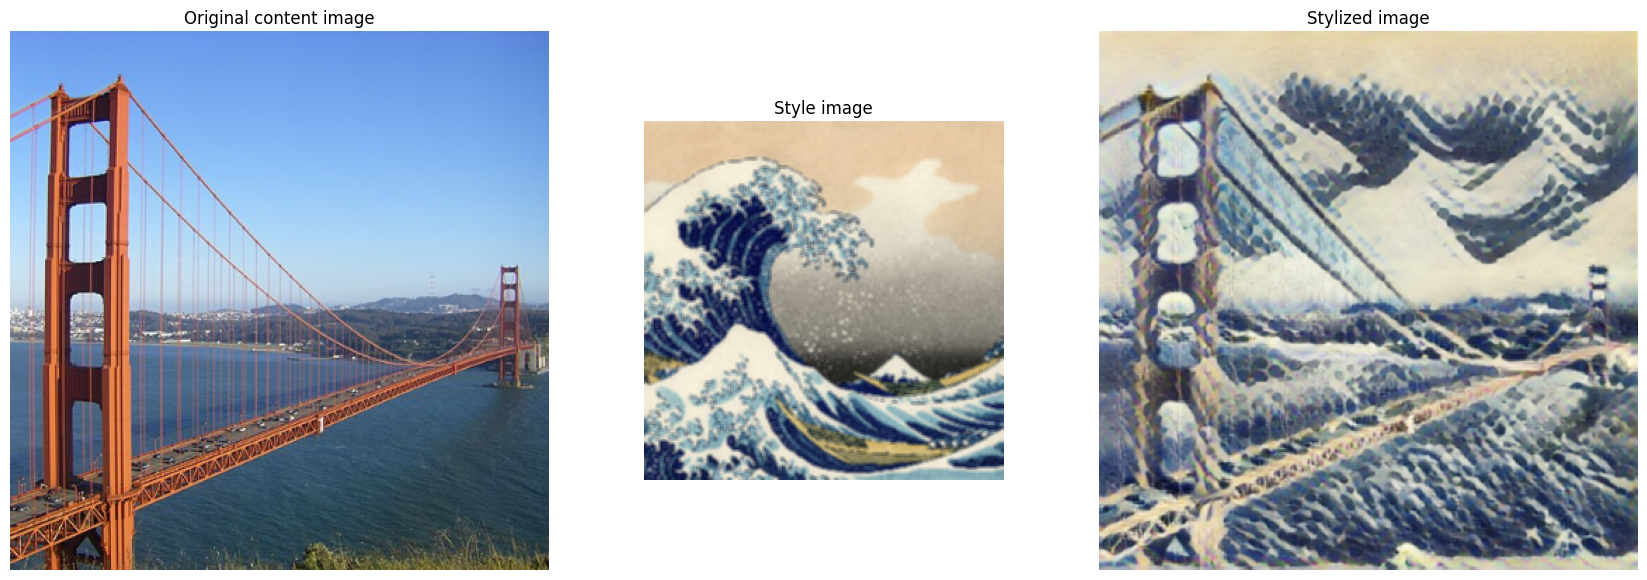

In [8]:
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])